# GCExplainer

In [1]:
import os,sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

---

### Model & Data

In [2]:
# Data

from src.datasets.BACH import BACH
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose, KNNGraph
import torch
graph_aug_val = Compose([KNNGraph(k=6)])

src_folder  = "C:\\Users\\aless\\Documents\\data"
tid,vid = BACH.get_train_val_ids(src_folder)
train_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=tid,pre_encoded=True)
val_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=vid,pre_encoded=True)

train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

print(len(train_loader))
print(len(val_loader))

308
76


In [3]:
# Model

from src.model.architectures.cancer_prediction.cancer_gnn import CancerGNN

model = CancerGNN.load_from_checkpoint(os.path.join(parent,"model", "GCN_Long.ckpt"),WIDTH=32,HEIGHT=7)
model.eval()
model.requires_grad_(False)
print(model.predictor)

Sequential(
  (0): Dropout(p=0.4, inplace=False)
  (1): Linear(in_features=64, out_features=32, bias=True)
  (2): BatchNorm1d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0, inplace=False)
  (5): Linear(in_features=32, out_features=4, bias=True)
)


---
## Dataset Metrics

In [4]:
import torch
def calculate_set_metric(loader,model,metric):
    tot = 0
    for batch in loader:
        ans = model(batch.x,batch.edge_index,batch.batch)
        tot += metric(ans,batch.y)
    return tot/len(loader)

def accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat == y).sum()

def cancer_accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat <=1) ==(y<=1 ).sum()
    
print("Training Loss",calculate_set_metric(train_loader,model,torch.nn.CrossEntropyLoss()))
print("Validation Loss",calculate_set_metric(val_loader,model,torch.nn.CrossEntropyLoss()))
print("Training Accuracy",calculate_set_metric(train_loader,model,accuracy))
print("Validation Accuracy",calculate_set_metric(val_loader,model,accuracy))
print("Training Cancer Accuracy",calculate_set_metric(train_loader,model,cancer_accuracy))
print("Validation Cancer Accuracy",calculate_set_metric(val_loader,model,cancer_accuracy))


Training Loss tensor(0.3051)
Validation Loss tensor(0.5629)
Training Accuracy tensor(0.9318)
Validation Accuracy tensor(0.8158)
Training Cancer Accuracy tensor([0.9708])
Validation Cancer Accuracy tensor([0.8684])


---

### Get Raw Activations

In [5]:

# Attach the hook

batch = next(iter(train_loader))
raw_activations = torch.zeros(0,32)

def append_raw_activations(self, input, output):
    global raw_activations
    raw_activations = torch.cat((raw_activations,output),dim=0)



model.gnn.conv[-1].register_forward_hook(append_raw_activations)



In [6]:
# Acquire the activations
raw_activations = torch.zeros(0,32)
predictions = torch.zeros(0)
ground = torch.zeros(0)
for batch in train_loader:
    num_elems = batch.x.shape[0]
    predictions = torch.cat([predictions,torch.zeros(num_elems)+model(batch.x,batch.edge_index,batch.batch).argmax()])
    ground = torch.cat([ground,(torch.zeros(num_elems)+batch.y)])

predictions = torch.as_tensor(predictions)
ground = torch.as_tensor(ground)
#for batch in val_loader:
#    model(batch.x,batch.edge_index,batch.batch)

In [7]:
print(raw_activations.shape)

torch.Size([280840, 32])


In [8]:
assert raw_activations.shape[0] == predictions.shape[0]

---
# K Means

In [9]:
def nearest_mean(x,means):

    delta = (means - x)**2
    dists = delta.sum(axis=1)
    return dists.argmin()

def cluster(obs,means,k):
    clusters = [[] for i in range(k)]
    for i,x in enumerate(obs):
        clusters[nearest_mean(x,means)].append(i)
    return clusters


In [10]:

from scipy.cluster.vq import kmeans
import numpy as np
k_small = 6
k_large = 20

tsne_size = 10000

obs = raw_activations.detach().numpy()
mu,sigma = obs.mean(axis=0),obs.std(axis=0)

print(len(obs))
def whiten(obs):
    return (obs - mu)/sigma

obs_white = whiten(obs)
means_small,_ = kmeans(obs_white,k_or_guess=k_small)
means_large,_ = kmeans(obs_white,k_or_guess=k_large)



np.random.seed(7)
subset = np.random.choice(np.arange(len(obs)),size=tsne_size,replace=False)
obs = obs[subset]
obs_white = whiten(obs)

clusters_small = cluster(obs_white,means_small,k_small)
clusters_large = cluster(obs_white,means_large,k_large)


280840


---
# Vizualize Explanations

In [11]:

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA



t =TSNE(n_components=2,learning_rate ='auto',verbose=2,perplexity = 1000,n_iter=700).fit_transform(obs_white)
#reducer = PCA(n_components=2).fit(obs)
#reducer = KernelPCA(n_components=2,kernel="rbf",degree=2).fit(smaller_obs)

d:\Documents\git\XAI-Cancer-Diagnosis\XAI-Cancer-Diagnosis\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 3001 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 4.219s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.521837
[t-SNE] Computed conditional probabilities in 7.331s
[t-SNE] Iteration 50: error = 55.6525993, gradient norm = 0.0000006 (50 iterations in 14.473s)
[t-SNE]

In [12]:

import matplotlib.pyplot as plt
from matplotlib import cm

def plot_concept_clusters(cluster_ids,values):
    f = plt.figure(figsize=(10,10))
    plt.axis("off")
    colours = cm.rainbow(np.linspace(0,1,len(cluster_ids)))
    for i,clust_ids in enumerate(cluster_ids):
        v = values[clust_ids]
        x,y = v[:,0],v[:,1]
        plt.scatter(x,y,color=colours[i])
    plt.show()

def plot_cancer_clusters(cancer_type,values):
    colours = cm.rainbow(np.linspace(0,1,4))
    for i in range(4):
        nodes_with_cancer_type = (cancer_type==i)
        v = values[nodes_with_cancer_type]
        x,y = v[:,0],v[:,1]
        plt.scatter(x,y,color=colours[i])
        plt.show()

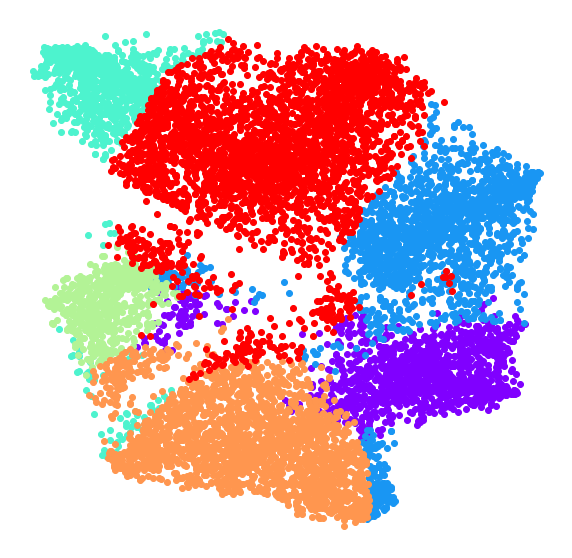

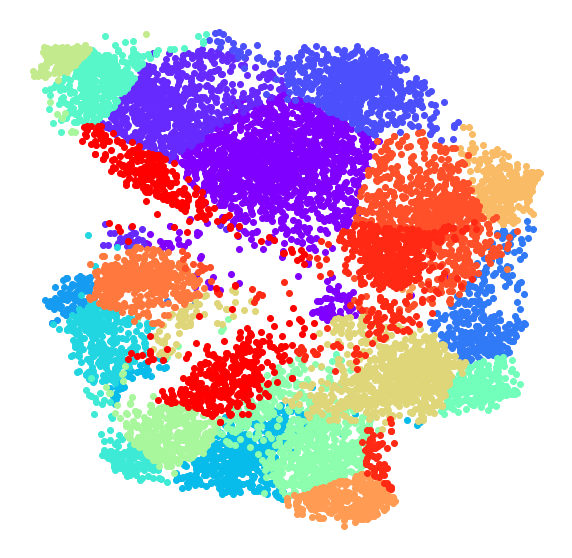

280840


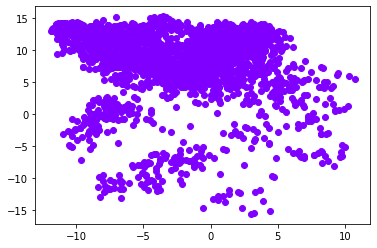

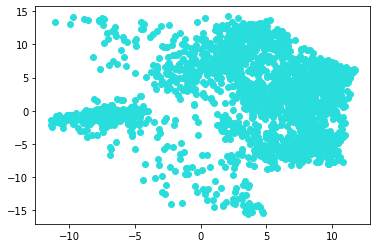

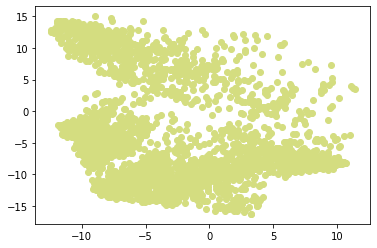

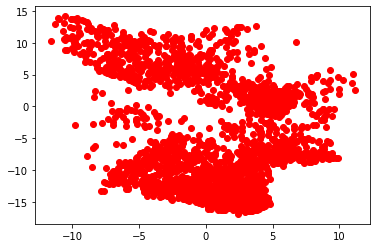

In [13]:
plot_concept_clusters(clusters_small,t) # clusters and t must be whitened
plot_concept_clusters(clusters_large,t) # clusters and t must be whitened
print(len(predictions))
plot_cancer_clusters(predictions[subset],t)

---
# Concept Completeness

In [14]:
# Activation Graph to Concept Graph


# Attach the hook

activations = []

def save_activation_graph(self, input, output):
    global activations
    activations.append(output)



model.gnn.conv[-1].register_forward_hook(save_activation_graph)



In [97]:
from torch.nn.functional import one_hot

def activation_to_concept(activation,means):
    return one_hot(torch.as_tensor(nearest_mean(activation,means)),len(means))

def activation_to_concept_graph(activations,means,k):
    output = torch.zeros(0,k)
    for i in range(len(activations)):
        concept = activation_to_concept(whiten(activations[i]).numpy(),means).unsqueeze(0)
        output = torch.cat([output,concept],dim=0)
    return output


def predict_activation_concept_from_graph(graph,means,k):
    global activations
    activations = []
    model(graph.x,graph.edge_index,graph.batch)
    ag = activations[0]
    return ag,activation_to_concept_graph(ag,means,k)



In [16]:

from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.data import Data

def vizualize_concept_graph(graph,means,k):
    print(graph.y)
    x = predict_concept_graph(graph,means,k)
    print((x.sum(dim=0)>(len(x)/10)).sum())
    edge_index  = graph.edge_index
    pos = {i:tuple(graph.pos[i]) for i in range(len(graph.pos))}
    colours = cm.rainbow(np.linspace(0,1,k))
    node_colours = [colours[i] for i in x.argmax(dim=1)]
    
    g = Data(x=x,edge_index=edge_index,pos=pos)
    G = to_networkx(graph,to_undirected=True)

    f,ax = plt.subplots(1,1,figsize=(70,70))
    nx.draw(G,pos=pos,node_color=node_colours,node_size=500)
    plt.show()

tensor([0])
tensor(2)


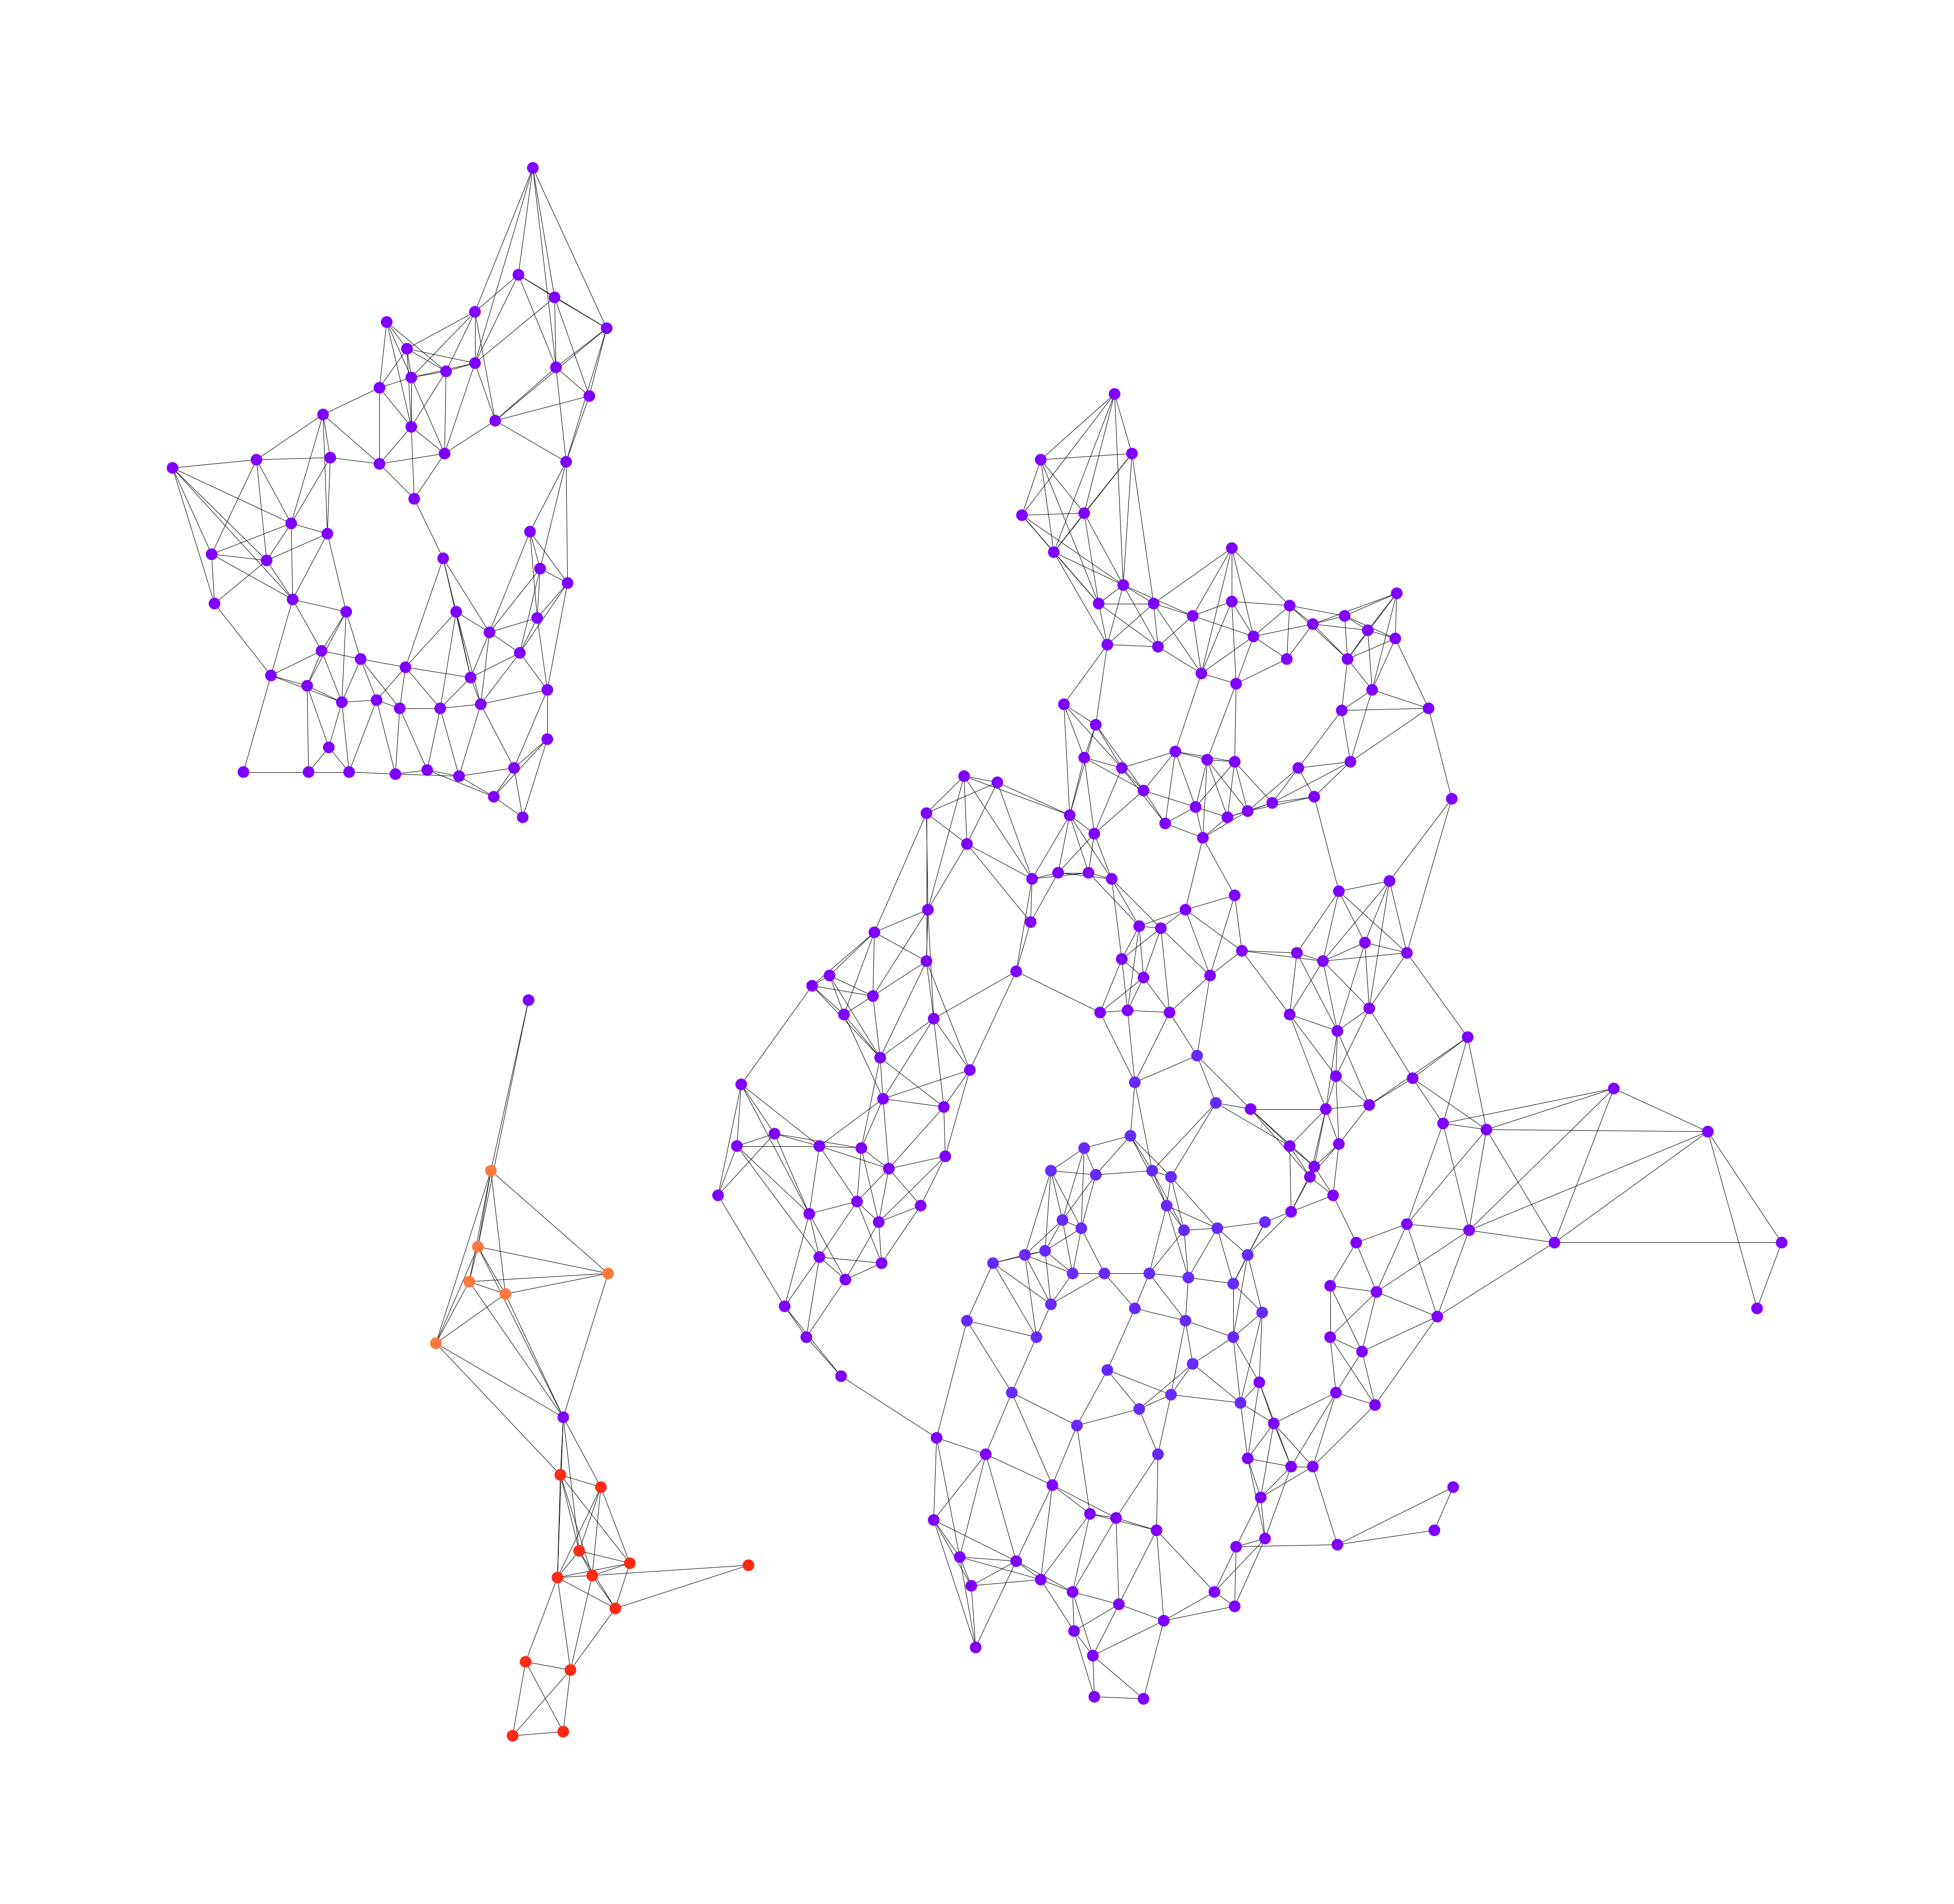

In [78]:
vizualize_concept_graph(next(iter(train_loader)),means_large,k_large)

---

In [19]:
def concept_vs_cancer(loader): return [(predict_concept_graph(batch,means_large,k_large).mean(dim=0),batch.y) for batch in loader]

In [20]:
x_train = np.array(list(map(lambda x:list(map(lambda y:y.item(),x[0])),concept_vs_cancer(train_loader))))
y_train = np.array(list(map(lambda x:x[1].item(),concept_vs_cancer(train_loader))))

x_val = np.array(list(map(lambda x:list(map(lambda y:y.item(),x[0])),concept_vs_cancer(val_loader))))
y_val = np.array(list(map(lambda x:x[1].item(),concept_vs_cancer(val_loader))))

AttributeError: 'GlobalStorage' object has no attribute 'means'

In [ ]:
def plot_agg_concept_for_class(cls,x,y):
    f = plt.figure(figsize=(20,10))
    ind = y==cls
    assert len(x) == len(y)

    plt.imshow(x[ind].reshape(k,-1))


In [ ]:
plot_agg_concept_for_class(1,x_train,y_train)

In [ ]:
torch.as_tensor(x_train).max(dim=0)

In [ ]:
X_train = torch.zeros(0,k)
Y_train = torch.zeros(0)

for graph in train_loader:
    num_nodes = len(graph.x)
    y = torch.zeros(num_nodes) + graph.y
    x = predict_concept_graph(graph,means,k)
    X_train = torch.cat([X_train,x],dim=0)
    Y_train = torch.cat([Y_train,y],dim=0)

In [ ]:
len(X_train),len(Y_train),(Y_train==3).sum()

In [ ]:
X_val = torch.zeros(0,k)
Y_val = torch.zeros(0)

for graph in val_loader:
    num_nodes = len(graph.x)
    y = torch.zeros(num_nodes) + graph.y
    x = predict_concept_graph(graph)
    X_val = torch.cat([X_val,x],dim=0)
    Y_val = torch.cat([Y_val,y],dim=0)

In [ ]:
print((Y_val<=1))

---
### CBE

In [ ]:
## Linear Model
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree as tree


l = tree.DecisionTreeClassifier(criterion="entropy").fit(X_train,Y_train)

tree.plot_tree(l)

print(l.score(X_train,Y_train))
print(l.score(X_val,Y_val))



In [21]:
# See P(class|concept)
from tqdm import tqdm
from torch.nn.functional import normalize


def class_concept_joint_frequency(CLS,CONCEPT,k):
    class_concept = torch.zeros(4,k)
    for cons,cl in tqdm(zip(CONCEPT,CLS)):
        class_concept[cl.int(),cons.argmax()] += 1
    return class_concept
    

In [22]:

def class_condition_concepts_prob(joint_freq,concepts): # concepts in one_hot_form
    output = torch.zeros(4)
    joint_freq+=1
    def _p_class(cl): return joint_freq[cl].sum()/joint_freq.sum()
    def _p_concept(cons): return joint_freq[:,cons].sum()/joint_freq.sum()
    def _p_concept_given_class(cons,cl): return joint_freq[cl,cons]/joint_freq[cl].sum()
    for cl in range(4):
        tot = torch.log(_p_class(cl))
        for cons in concepts:
            cons = cons.argmax()
            tot  += torch.log(_p_concept_given_class(cons,cl))
            tot -= torch.log(_p_concept(cons))
        output[cl] = tot
    return output       
        
    

In [23]:
freq = class_concept_joint_frequency(Y_train,X_train)

NameError: name 'Y_train' is not defined

In [24]:
class_condition_concepts_prob(freq,X_train[0:10000])

NameError: name 'freq' is not defined

In [25]:
from torch.nn.functional import normalize

z = normalize(freq,dim=1,p=1)
y = torch.zeros(k,2)
y[:,0] = z[:,0]+z[:,1]
y[:,1] = z[:,2]+z[:,3]
y

NameError: name 'freq' is not defined

In [26]:
z

NameError: name 'z' is not defined

---
# Deducing K


1) Choose K
2) Get Convert list of graphs to list of (activation, graph id)
3) Get list (graph_id, ground_truth, pred_truth)
4) Generate means and hence concepts from activations
5) Get concepts from activations
6) Use decision tree to predict (concept-> cancer_type)
7) Evaluate how accurate
8) **Define concept prevelance score** and evaluate. If below certain threshold
9) Increment K and plot.

In [27]:
from tqdm import tqdm
import sklearn.tree as tree

def first(x): return x[0]
def second(x): return x[1]
def third(x): return x[2]



def deduce_k(train_loader,val_loader,model,max_k=60,increments=6,start_k=10):
    global activations
    ks = []
    dt_scores = []
    concept_accs = []
    min_concept_prev = []
    max_concept_prev = []
    for k in tqdm(range(start_k,max_k,increments)):
        #1
        act_graph = []
        graph_gt_pred = []
        #2 & 3
        for i,graph in enumerate(train_loader):
            activations = []
            pred = model(graph.x,graph.edge_index,graph.batch).argmax(dim=1).squeeze()
            act_graph += [(act, i) for act in activations[0]]
            graph_gt_pred += [(i,graph.y.squeeze(),pred)]
        graph_gt_pred = sorted(graph_gt_pred)
        
        
        val_act_graph = []
        val_graph_gt_pred = []
        #2 & 3
        for i,graph in enumerate(val_loader):
            activations = []
            pred = model(graph.x,graph.edge_index,graph.batch).argmax(dim=1).squeeze()
            val_act_graph += [(act, i) for act in activations[0]]
            val_graph_gt_pred += [(i,graph.y.squeeze(),pred)]
        val_graph_gt_pred = sorted(val_graph_gt_pred)
        
        
        
        
        #4
        
        obs = torch.stack(list(map(lambda x:x[0],act_graph))).numpy()
        obs_white = whiten(obs)
        means,_ = kmeans(obs_white,k_or_guess=k)
        clusters = cluster(obs_white,means,k)
        
        #5
        concepts_graph = list(map(lambda p:(activation_to_concept(whiten(p[0].numpy()),means),p[1]),act_graph)) # DO NOT FORGET TO WHITEN
        concepts_by_graph = [torch.stack([c[0] for c in concepts_graph if c[1]==g]) for g in range(len(graph_gt_pred))]
        
        val_concepts_graph = list(map(lambda p:(activation_to_concept(whiten(p[0].numpy()),means),p[1]),val_act_graph)) # DO NOT FORGET TO WHITEN
        val_concepts_by_graph = [torch.stack([c[0] for c in val_concepts_graph if c[1]==g]) for g in range(len(val_graph_gt_pred))]
        
        #6
        concepts = torch.stack(list(map(first,concepts_graph)))
        classes = torch.as_tensor(list(map(lambda x:graph_gt_pred[x[1]][1].item(),concepts_graph)))
        
        val_concepts = torch.stack(list(map(first,val_concepts_graph)))
        val_classes = torch.as_tensor(list(map(lambda x:val_graph_gt_pred[x[1]][1].item(),val_concepts_graph)))
        
        dt = tree.DecisionTreeClassifier(criterion="entropy").fit(concepts.numpy(),classes.numpy())
        
        
        #6.5
        
        joint_freq = class_concept_joint_frequency(classes,concepts,k)
        val_concept_pred = torch.as_tensor(list(map(lambda i: class_condition_concepts_prob(joint_freq,val_concepts_by_graph[i]).argmax(), range(len(val_graph_gt_pred)))))
        gt = torch.as_tensor(list(map(second,val_graph_gt_pred)))
        pred = torch.as_tensor(list(map(third,val_graph_gt_pred)))
        
        concept_acc = (val_concept_pred==gt).sum()/len(gt)
        
        concept_prevalence = torch.sum(torch.stack(list(map(lambda x: (x.sum(dim=0)>=len(x)/20),concepts_by_graph))),dim=0)
        #7
        ks += [k]
        dt_scores += [dt.score(val_concepts.numpy(),val_classes.numpy())]
        concept_accs += [concept_acc]
        min_concept_prev += [concept_prevalence.min()]
        max_concept_prev += [concept_prevalence.max()]
        
    return ks,dt_scores,concept_accs,min_concept_prev,max_concept_prev
        
#ks,dts,concept_accs,min_concept_prev,max_concept_prev = deduce_k(train_loader,val_loader,model,max_k=35,increments=5,start_k=5)

In [28]:
print(min_concept_prev)

NameError: name 'min_concept_prev' is not defined

In [29]:
plt.plot(ks,dts)
plt.plot(ks,concept_accs)
plt.show()
plt.plot(ks,min_concept_prev)
plt.plot(ks,max_concept_prev)
plt.show()

NameError: name 'ks' is not defined

In [30]:
plt.plot(ks,dts)
plt.plot(ks,concept_accs)
plt.show()

NameError: name 'ks' is not defined

---
# Concept Discovery

In [31]:
def generate_k_concepts(model,train_loader,k):
    act_graph = []
    graph_gt_pred = []
    #2 & 3
    for i,graph in enumerate(train_loader):
        activations = []
        pred = model(graph.x,graph.edge_index,graph.batch).argmax(dim=1).squeeze()
        act_graph += [(act, i) for act in activations[0]]
        graph_gt_pred += [(i,graph.y.squeeze(),pred)]
    graph_gt_pred = sorted(graph_gt_pred)
    
    
    
    #4
    
    obs = torch.stack(list(map(lambda x:x[0],act_graph))).numpy()
    obs_white = whiten(obs)
    means,_ = kmeans(obs_white,k_or_guess=k)
    return means

---
# Concept Representation

In [105]:
import networkx as nx
from torch_geometric.utils import to_networkx, from_networkx

k = k_large
means = means_large

def activation_graph_to_concept_graph(graph,means,k):
    output = graph.clone()
    output.activation,output.x = predict_activation_concept_from_graph(graph,means,k)
    return output


def disect_concept_graph(concept_graph,min_subgraph_size=5):
    graph = concept_graph.clone()

    left_nodes,right_nodes = concept_graph.x[graph.edge_index[0,:]].argmax(dim=1),concept_graph.x[graph.edge_index[1,:]].argmax(dim=1)

    keep_edge = left_nodes==right_nodes
    print(keep_edge.sum())
    graph.edge_index = graph.edge_index[:,keep_edge]
    
    G = to_networkx(graph, to_undirected=True, node_attrs=['x','activation','pos'])
    
    sub_graphs = [G.subgraph(g) for g in nx.components.connected_components(G) if len(g) >= min_subgraph_size]
    for i,g in enumerate(sub_graphs):
        g = from_networkx(g,group_node_attrs=['activation','x','pos'])
        g.pos = g.x[:,-2:]
        g.activation = g.x[:,:32]
        g.x = g.x[:,32:-2]
        g.img_id = graph.img_id

        g.concept = g.x[0].argmax()
        sub_graphs[i] = g
    return sub_graphs


        
    

In [106]:
graph = next(iter(train_loader))


cg = activation_graph_to_concept_graph(graph[0],means,k)
print(disect_concept_graph(cg,min_subgraph_size=1))

20
tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])
tensor(1667)
Data(edge_index=[2, 62], x=[12, 20], pos=[12, 2], activation=[12, 32], img_id='n001', concept=18)


In [87]:
# GET ALL CANDIDATE EXEMPLARY GRAPHS
exemplary_concept_graphs = [[] for i in range(k)]

for i,graph in tqdm(enumerate(train_loader),total=len(train_loader)):
    sub_graphs = disect_concept_graph(activation_graph_to_concept_graph(graph[0],means,k),min_subgraph_size=30)
    for sg in sub_graphs:
        exemplary_concept_graphs[sg.concept].append(sg)



100%|██████████| 308/308 [01:45<00:00,  2.91it/s]


In [88]:
list(map(len,exemplary_concept_graphs))

[173,
 59,
 89,
 23,
 8,
 49,
 29,
 15,
 33,
 35,
 46,
 30,
 14,
 72,
 32,
 37,
 29,
 61,
 48,
 51]

In [90]:
# FILTER FOR 3 most Interesting

def score_subgraph(sg,mean):
    dists = ((sg.x - mean)**2).sum(dim=1)
    return dists.min()
for i in tqdm(range(k)):
    best_examples = sorted(map(lambda x:(score_subgraph(x,means[i]),x),exemplary_concept_graphs[i]))
    best_examples = best_examples[:min(3,len(best_examples))]
    exemplary_concept_graphs[i] = best_examples
    
exemplary_concept_graphs

  0%|          | 0/20 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (169,20) (32,) 